In [1]:
# Author Jiayi Shou 
# Apr 2021
# This program compares the performance of active learning and no active 
# learning with Gaussian Process Regressor. The data it takes are kmer protein 
# sequences(in protein alphabet) and their corresponding protein affinity 
# values(continuous value) in a csv file.
# The protein alphabet is first tranformed to binary vectors using one hot encoding so 
# that each letter becomes a feature. It then trains Gaussian Process Regressor using 
# active learning with query strategy picking samples with highest standard deviation 
# according to the regressor prediction. Note: currently, the active learning performs 
# worse than no active learning.

# This sample data set is protein 9mers and their MHC class I binding affinity.

import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF,WhiteKernel,ExpSineSquared
from sklearn.metrics import r2_score

from modAL.models import ActiveLearner
from modAL.utils.selection import multi_argmax


seed = 8
random.seed(seed)
np.random.seed(seed)

In [5]:
data = np.loadtxt('Protein_affinity_sample.csv', dtype = str, delimiter = ',')[1:]
data = shuffle(data, random_state=0)

X = data[:,2]
y = data[:,3].astype(float)
n_initial = 200
n_queries = 50 #100
step = 50

In [6]:
X_encoded = kmer_one_hot_encoder(X)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.33)

_, history_regressor_AL = make_regressor_AL_accuracy_history(X_train, y_train, X_test, y_test, n_initial, n_queries, step)
_, history_regressor = make_regressor_accuracy_history(X_train, y_train, X_test, y_test, n_initial, n_queries, step)

Active learning progress at  0.0 %, current score:  0.42682556533681737
Active learning progress at  20.0 %, current score:  0.4385290872656554
Active learning progress at  40.0 %, current score:  0.45108813226720423
Active learning progress at  60.0 %, current score:  0.4572056277168953
Active learning progress at  80.0 %, current score:  0.4580948489261104
progress at  0.0 %, current score:  0.412288665929173
progress at  20.0 %, current score:  0.4195428664515134
progress at  40.0 %, current score:  0.46006646298170284
progress at  60.0 %, current score:  0.49161645206705795
progress at  80.0 %, current score:  0.4924379826411581


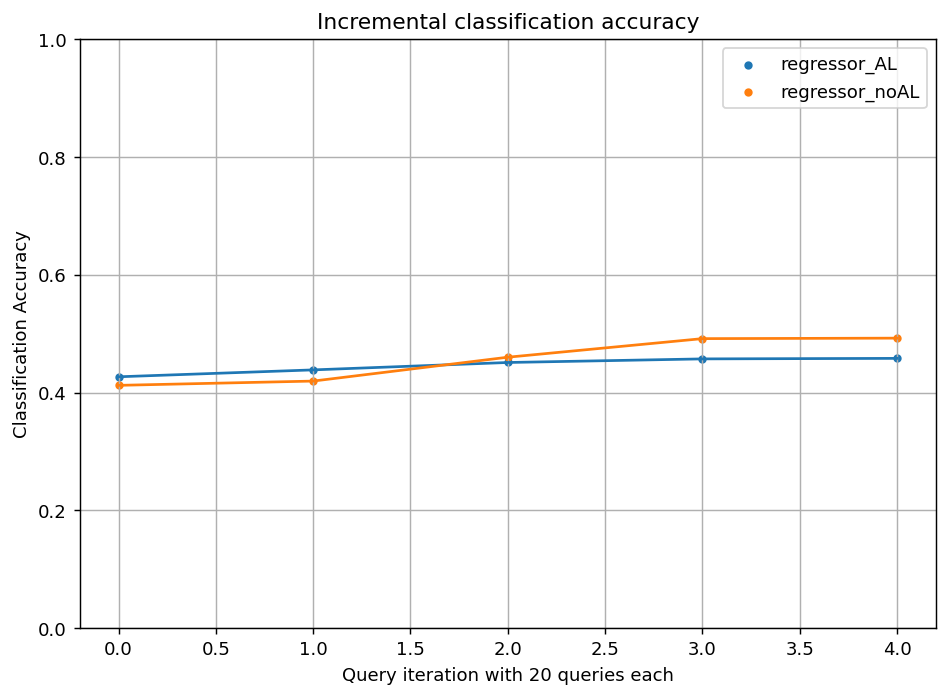

In [7]:
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(history_regressor_AL)
ax.scatter(range(len(history_regressor_AL)), history_regressor_AL, s=13, label = "regressor_AL")

ax.plot(history_regressor)
ax.scatter(range(len(history_regressor)), history_regressor, s=13,label = "regressor_noAL")

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration with 20 queries each')
ax.set_ylabel('Classification Accuracy')
ax.legend()

plt.show()

In [3]:
# kmer_one_hot_encoder takes in an array of kmers(string) and returns
# the encoded array of kmers as a matrix of size #kmers * k^(#kmer alphabet)
def kmer_one_hot_encoder(Xarray):
    #split each entry in X into characters 
    X_split = [[char for char in word] for word in Xarray]
    #Set OneHotEncoder, use the default setting
    OHE = OneHotEncoder(handle_unknown='ignore')
    X_encoded = OHE.fit_transform(X_split).toarray()
    return X_encoded

# GP_regression_std takes the regressor, encoded input data and returns
# the query ID and n-instances(batch mode) with the highest standard deviation.
def GP_regression_std(regressor, X_encoded, n_instances = step):
    _, std = regressor.predict(X_encoded, return_std=True)
    query_idx = multi_argmax(std, n_instances = n_instances)
    return query_idx, X_encoded[query_idx]

# set the initial training set(by random sampling) to start the active learner
def set_initial(X_train, y_train, n_initial):
    initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
    X_initial, y_initial = X_train[initial_idx].reshape(n_initial, -1), y_train[initial_idx].reshape(n_initial, -1)
    return X_initial, y_initial, initial_idx

# Make n batches of queries and train the regressor, with each batch step number of samples.
# It also log the accuracy each time by calculating the r2 score.
def make_queries(X_train, y_train, X_test, y_test, n_queries, step, regressor):
    history_regressor = []
    
    for idx in range(n_queries):
        query_idx, query_instance = regressor.query(X_train, n_instances = step)
        regressor.teach(X_train[query_idx].reshape(step,-1), y_train[query_idx].reshape(step,-1))
        X_train, y_train = (np.delete(X_train, query_idx, axis=0), np.delete(y_train, query_idx))
        y_pred_final = regressor.predict(X_test, return_std=False)
        r2=r2_score(y_test,y_pred_final)
        history_regressor.append(r2)
    
        if idx%(n_queries/5)==0:
            print('Active learning progress at ', idx/n_queries*100, '%, current score: ', r2)
    return regressor, history_regressor


In [4]:
# Takes in train and test data, train the regressor with n queries (each time query step samples)
# Returns the trained regressor and history of accurace with each query for later plots.
def make_regressor_AL_accuracy_history(X_train, y_train, X_test, y_test, n_initial, n_queries, step):
    X_initial, y_initial, initial_idx = set_initial(X_train, y_train, n_initial)
    
    kernel = RBF(length_scale= np.amax(y_train)+1, length_scale_bounds=(1e-2, 1e5)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(5e-10, 3e+1))

    regressor_GP = ActiveLearner(
        estimator=GaussianProcessRegressor(kernel=kernel, alpha=1e-10),
        query_strategy=GP_regression_std,
        X_training=X_initial, y_training=y_initial  
    )
    X_train, y_train = (np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx))
    regressor_GP, history_regressor_GP = make_queries(X_train, y_train, X_test, y_test, n_queries, step, regressor_GP)
    return regressor_GP, history_regressor_GP

# Takes in train and test data, train the regressor with incremental size of training data.
# Returns the trained regressor and the history of accurace with incremental training data size. 
def make_regressor_accuracy_history(X_train, y_train, X_test, y_test, n_initial, num_batch, batch_size):
    history = []
    
    kernel = RBF(length_scale= np.amax(y_train)+1, length_scale_bounds=(1e-2, 1e5)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(5e-10, 3e+1))
    GPR = GaussianProcessRegressor(kernel=kernel, alpha=1e-10)
    
    for idx in range(num_batch):
        idx_step = (idx)*batch_size+n_initial
        idx_random = np.random.choice(range(len(X_train)), size=idx_step, replace=False)
        GPR.fit(X_train[idx_random].reshape(len(idx_random),-1), y_train[idx_random])
        y_pred = GPR.predict(X_test)
        r2 = r2_score(y_test,y_pred)
        history.append(r2)

        if idx%(num_batch/5)==0:
            print('progress at ', idx/num_batch*100, '%, current score: ', r2)
    return GPR, history